# Geospatial Set Cover using Greedy Algorithm

Author: Jeff Nivitanont, GeoCARB Research Assistant

Location: University of Oklahoma

Packages: netCDF4, pandas, shapely, geopandas, matplotlib, cartopy, numpy

We are given the problem of optimizing the scan pattern for the GeoCARB satellite instrument set to launch in 2022. GeoCARB is a geostationary satellite that will be positioned at 0-85W and make daily observations of atmospheric CO2, CO, NH4, and SIF over the Americas.

The underlying mathematical problem related to optimizing the scanning pattern is called the Geometric Set Cover problem. Given a set of points in 2-D space and a set of covers, what is the optimal covering set? This problem is known to be NP-Hard so there are no efficient methods for straight-forward computation. However, there are heuristic methods for finding a set cover, though they do not necessarily yield optimal covers. We start our exploration into this problem with the Greedy Heuristic. 

In [1]:
%matplotlib inline
from netCDF4 import Dataset
from gc_set_cover import *
import shapely.geometry as sgeom
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from shapely.ops import unary_union
from descartes.patch import PolygonPatch
from sklearn.utils.extmath import cartesian

In [3]:
##loading nc4 file
nc_f = 'small_scan_blocks.nc4'  # Your filename
nc_fid = Dataset(nc_f, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class

##blocks are groups into 5 min blocks
## naming format is 'degrees lat - scan time from E-W'
centroid_lat_lon = [group for group in nc_fid.groups] 
print (centroid_lat_lon)

['0.00000S_36.82104W', '0.00000S_39.72937W', '0.00000S_42.42474W', '0.00000S_44.95184W', '0.00000S_47.34229W', '0.00000S_49.61948W', '0.00000S_51.80139W', '0.00000S_53.90207W', '0.00000S_55.93289W', '0.00000S_57.90320W', '0.00000S_59.82077W', '0.00000S_61.69217W', '0.00000S_63.52310W', '0.00000S_65.31848W', '0.00000S_67.08267W', '0.00000S_68.81949W', '0.00000S_70.53244W', '0.00000S_72.22467W', '0.00000S_73.89911W', '0.00000S_75.55835W', '0.00000N_77.20499W', '0.00000S_78.84134W', '0.00000N_80.46970W', '0.00000S_81.90314W', '10.47836S_35.34406W', '10.40801S_38.43777W', '10.34646S_41.27969W', '10.29192S_43.92691W', '10.24314S_46.41855W', '10.19925S_48.78284W', '10.15956S_51.04102W', '10.12358S_53.20944W', '10.09088S_55.30124W', '10.06115S_57.32697W', '10.03411S_59.29538W', '10.00955S_61.21387W', '9.98728S_63.08865W', '9.96716S_64.92523W', '9.94904S_66.72833W', '9.93283S_68.50214W', '9.91842S_70.25046W', '9.90575S_71.97665W', '9.89474S_73.68384W', '9.88534S_75.37494W', '9.87750S_77.05258W

Creating a GeoSeries of scan blocks. We use the GeoPandas package because it combines the quick data analysis tools of Pandas with the geometric analysis tools of Shapely. We like the Shapely package for geometric analysis because it is a wrapper for the widely used C GEOS and Java Topology Suite. For the block names, we use the centroid 'lat, lon' coordinates.

We use the built-in geopandas dataset to load geospatial data and select N.am and S.am geometries. The Data is 1:110m from NaturalEarth, includes cultural and physical information (i.e. countries, pop, geometries, etc). NaturalEarth data is a free for use and supported by NACIS (North American Cartographic Information Society). http://www.naturalearthdata.com/

In [4]:
#for converting lat/lon to Geo
geo = ccrs.Geostationary(central_longitude=-85.0, satellite_height=42.336e6)
geo_proj4 = geo.proj4_init
latlon = {'init' :'epsg:4326'}

#creating geometries from scan block info using the corners
pgon = list()
blockname = []
for i in range(len(centroid_lat_lon)):
    temp_lon_arr = (nc_fid.groups[centroid_lat_lon[i]].variables['longitude_centre'][:].T - 360.)
    temp_lon_crns = [temp_lon_arr[0,-1],  #upper left corner
                     temp_lon_arr[0,0],   #upper right corner
                     temp_lon_arr[-1,0],  #lower right corner
                     temp_lon_arr[-1,-1]] #lower left corner
    temp_lat_arr = (nc_fid.groups[centroid_lat_lon[i]].variables['latitude_centre'][:].T)
    temp_lat_crns = [temp_lat_arr[0,-1],  #upper left corner
                     temp_lat_arr[0,0],   #upper right corner
                     temp_lat_arr[-1,0],  #lower right corner
                     temp_lat_arr[-1,-1]] #lower left corner
    temp_scan = zip(temp_lon_crns, temp_lat_crns) #(lon, lat) to conform to Cartesian (x, y)
    pgon.append(sgeom.Polygon(temp_scan))

#reframe as GeoSeries
blockset = gpd.GeoDataFrame( {'centroid_lat_lon' : centroid_lat_lon, 'geometry':pgon} )
blockset.crs = latlon #initialize the CRS

#convert lat/lon to geostationary coordinates using built-in Cartopy tools for analysis and plotting
blockset = blockset.to_crs(geo_proj4)
blockset = blockset[blockset['geometry'].is_valid].reset_index(drop=True) #takes out the blocks that scan into space
blockset = blockset.drop(where(blockset['geometry'].area > average(blockset.area))[0]).reset_index(drop=True) #drop blocks were generated with errors(size too large)


We then truncate our universe set at 50N and 50S to eliminate the extreme latitudes from the algorithms consideration.

In [6]:
#creating a bounding envelope for Universal set
#We are generally concerned with the land masses lying between 50N and 50S
envelope = sgeom.box(-130, -50, -30, 50)

df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
n_am = df.query('continent == "North America"')
caribbean = ['Bahamas', 'Cuba', 'Dominican Rep.', 'Haiti', 'Jamaica', 'Puerto Rico']
n_am = n_am[logical_not(n_am['name'].isin(caribbean))][['continent', 'geometry']] #remove caribbean islands
s_am = df.query('continent == "South America"')[['continent', 'geometry']]
frguiana = gpd.GeoDataFrame({'continent':'South America', 'geometry' : df[df['name'] == 'France'].intersection(envelope)}) #french guiana is listed under France < Europe
s_am = s_am.append(frguiana)
westhem = n_am.append(s_am)
continents = westhem.dissolve(by='continent')

U = continents.intersection(envelope)
U.crs = {'init' :'epsg:4326'}
U = U.to_crs(geo_proj4).buffer(0)  #a workaround commonly used in the
                                    #C GEOS package to ensure that valid geoms are labeled 'valid'

I had to buffer each scan block as a workaround to underlying floating point precision issues related to the intersection() function in the C GEOS package that the python Shapely package is wrapped around. Although, this won't be an issue with the integration into the instrument since each scan block will overlap the next. The ticket to fix the bug can be found here https://github.com/Toblerity/Shapely/issues/357

In [7]:
#fixing precision issues by adding a buffer
U_set = U.unary_union.buffer(0)
blockset = blockset[blockset.intersects(U_set)==True].reset_index(drop=True) #drop blocks that don't cover any land
blockset['geometry'] = blockset.buffer(5000)
coverage = blockset.unary_union
print('Containment:', coverage.contains(U_set))

#scan blocks aren't covering the Eastern portion of Nova Scotia
#so I'm subtracting the difference for the universe_set used in the algorithm
diff = U_set.difference(coverage).buffer(0)
universe_set = U_set.difference(diff).buffer(0)
print('Difference area =', diff.area)
print('New difference area =',universe_set.difference(coverage).area) 

Containment: False
Difference area = 220266444570.0599
New difference area = 0.0


The image generated below shows all potential 5-minute scan blocks in the set of candidate covers.

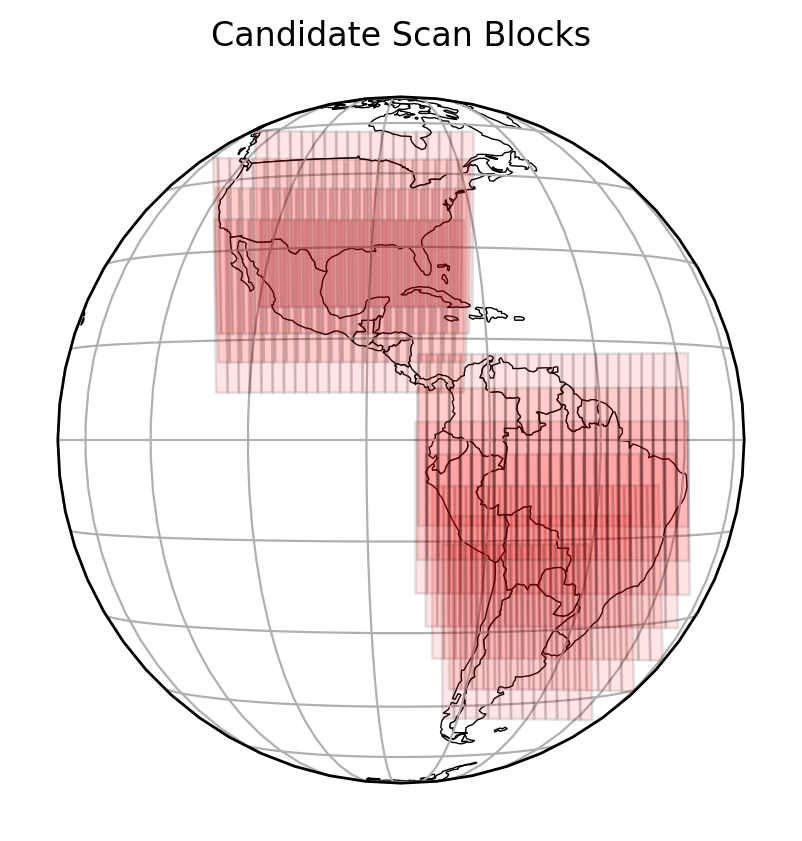

In [8]:
ax1= subplots(figsize=(5,5), dpi=200)
ax1 = axes(projection=geo)
ax1.add_feature(cfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '110m'), facecolor='white', edgecolor='black', linewidth=0.5)
ax1.gridlines()
ax1.axis('scaled')
#built-in plotting function for geopandas objects
blockset.plot(ax=ax1, zorder=5, alpha=0.1, color='red', edgecolor='black')
title('Candidate Scan Blocks')
#plt.savefig('candidates2')
show()

The plot generated below shows the new universal set in blue, which you can see excludes the eastern part of Nova Scotia.

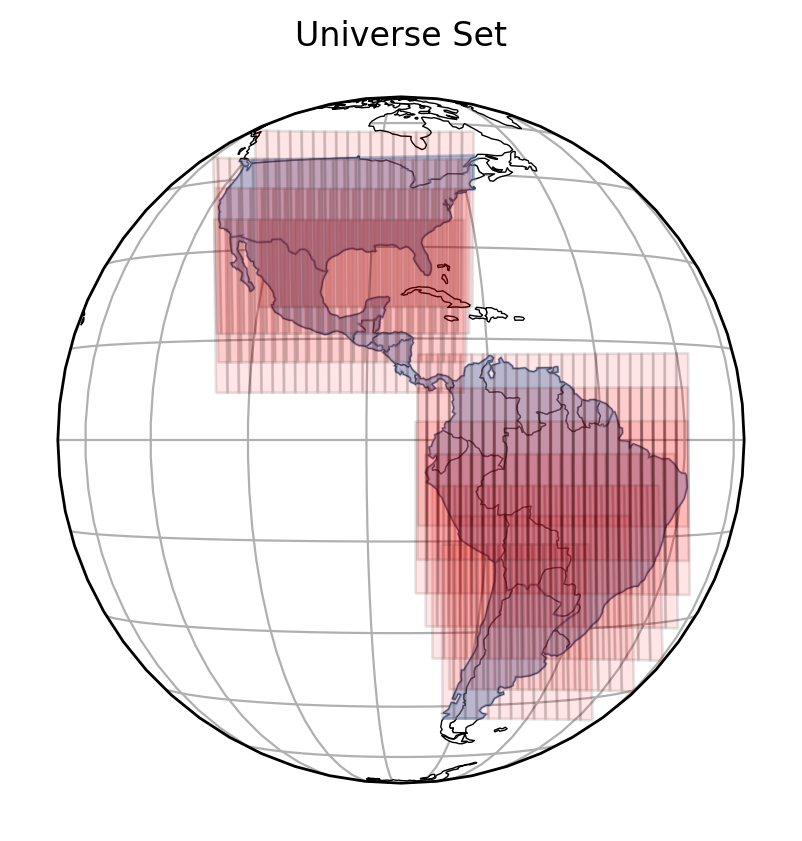

In [9]:
#plotting multipolygon geometry
#min_mesh = load('min_mesh_jan.npy')
BLUE = '#6699cc'
fig = plt.subplots(figsize=(5,5),dpi=200)
ax1 = plt.axes(projection=geo)
ax1.gridlines(zorder=0)
ax1.axis('scaled')
ax1.add_feature(cfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '110m'),
                facecolor='white', edgecolor='black', linewidth=0.5, zorder=1)
ax1.add_patch( PolygonPatch(polygon=universe_set, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
#ax1.add_patch( PolygonPatch(polygon=af_mesh.buffer(5000), color='red', alpha=0.5, zorder=3 ))
#blockset[blockset.intersects(universe_set)==True].plot(ax=ax1, alpha=0.1, facecolor='red',edgecolor='black', zorder=5)
blockset.plot(ax=ax1, alpha=0.1, facecolor='red',edgecolor='black', zorder=4)
#mesh = ax1.contourf(xv, yv, min_mesh, arange(2,8), zorder=2, transform=ccrs.PlateCarree(), cmap='autumn', alpha=0.5)
#colorbar(mesh, shrink=0.5 )
title('Universe Set')
savefig('universe_set_wcands')
show()

The cell below implements the Greedy Algorithm for finding a set cover. We first lay a mesh over our scanning area and calculate the Airmass Factor at discrete points in the mesh. The Airmass Factor mesh is from 50N to 50S and 130W to 30W and the discrete points are spaced at every half degree. The algorithm calculates the weight of each block as the area of the block coverage on our area of interest minus the overlapping area with previously selected blocks minus the distance from the last selected block all divided by the total airmass factor score of the block.

In [6]:
#%%time  // cell runtime on my laptop ~ 15 mins
x = linspace(-130, -30, 201)
y = linspace( 50, -50, 201)
#x = linspace(-130,-30, 101) #coarse
#y = linspace(50, -50, 101)  #coarse
xv, yv = meshgrid(x,y)  #creates a grid 

total_mesh = sgeom.MultiPoint(cartesian([x,y]))
af_mesh = transform(project, total_mesh)
af_mesh = af_mesh.intersection(universe_set)
weight_mesh = load('jan15_day_mesh.npy')
coverset = greedy_gc_mesh(blockset = blockset, universe_set = universe_set, mesh = af_mesh, weights = weight_mesh)
beep()

Then we plot the blocks that the algorithm has chosen.

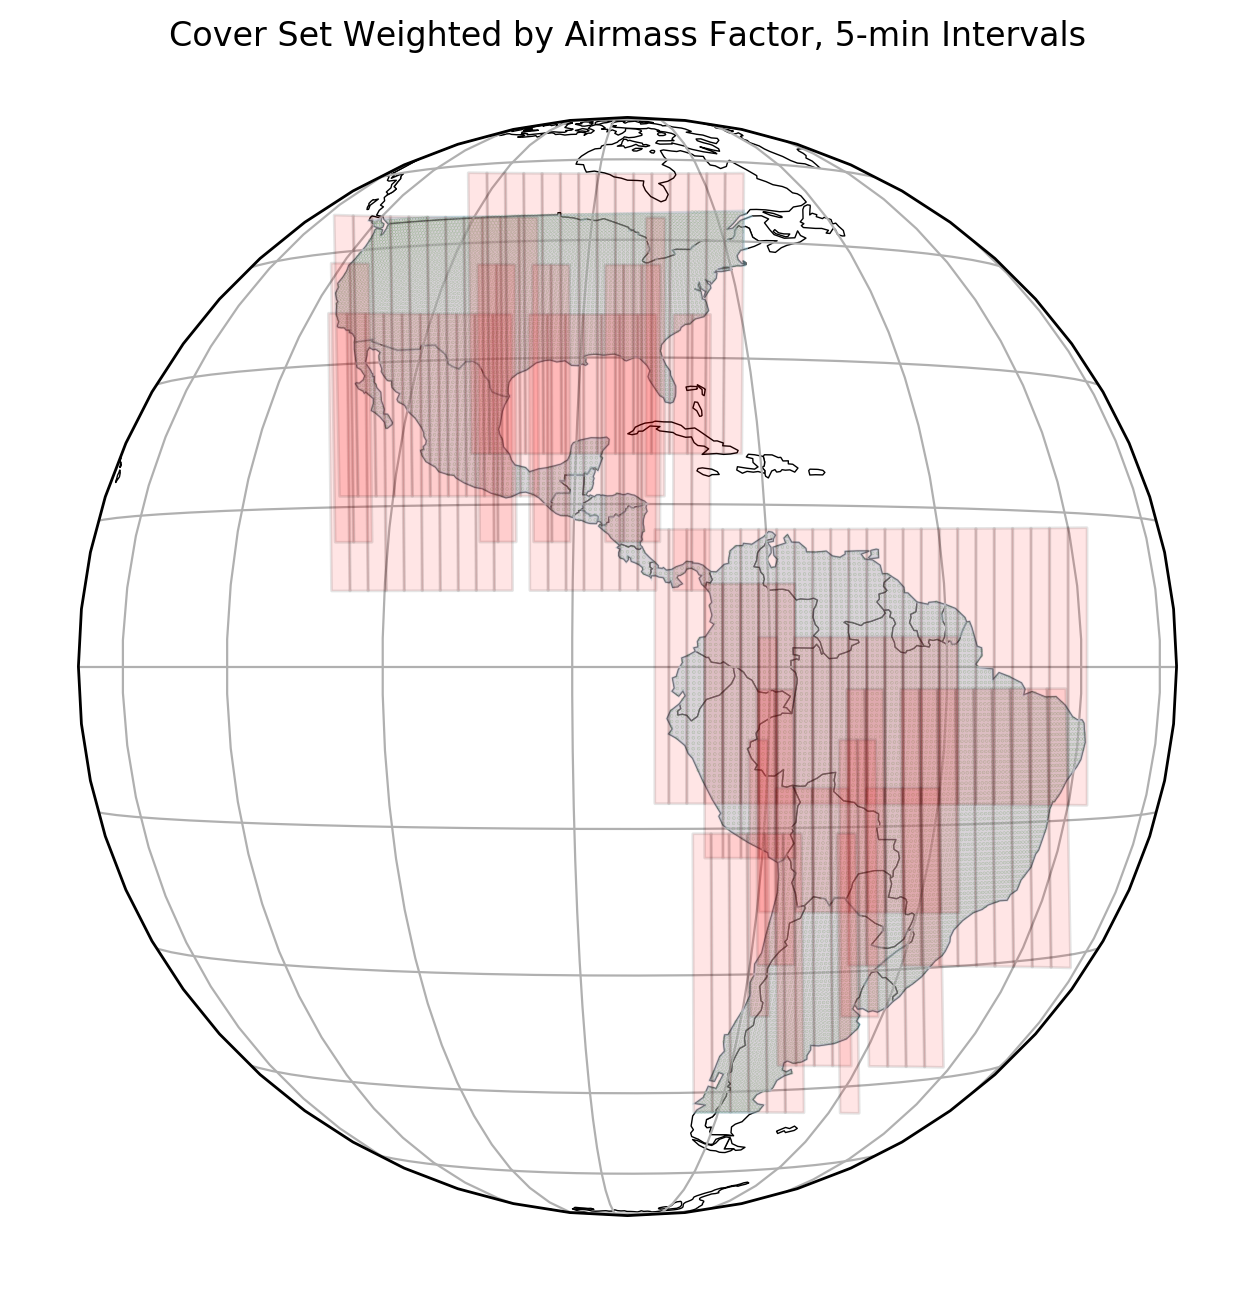

In [22]:
#mpl plot object
ax1= subplots(figsize=(8,8), dpi=200)
ax1 = axes(projection=geo)
ax1.add_feature(cfeat.NaturalEarthFeature('cultural', 'admin_0_countries', '110m'),
                linewidth=0.5,facecolor='white', edgecolor='black')
ax1.gridlines()
ax1.axis('scaled')
#U.plot(ax=ax1, zorder=4)
ax1.add_patch(PolygonPatch(universe_set, color='lightblue', alpha=0.5, zorder=4 ))
#ax1.add_patch(PolygonPatch(universe_set.difference(coverset1[:111].unary_union).buffer(1000), color='green', alpha=1, zorder=5 ))
ax1.add_patch(PolygonPatch(af_mesh.buffer(2000), color='green', alpha=0.3, zorder=5 ))
coverset.plot(ax=ax1, zorder=6, alpha=0.1, edgecolor='black', facecolor='red')
#coverset1[-25:].plot(ax=ax1, zorder=7, alpha=0.2, color='blue')
#cover_init[22:52].plot(ax=ax1, zorder=6, alpha=0.2, edgecolor='black', facecolor='red')
#mesh = ax1.contourf(xv, yv, min_mesh, arange(2,8), zorder=2, transform=ccrs.PlateCarree(), cmap='autumn', alpha=0.4)
#colorbar(mesh, shrink=0.5 )
title('Cover Set Weighted by Airmass Factor, 5-min Intervals')
savefig('coverset_5min5')
show()

In [23]:
#save outputs
coverset.to_pickle('coverset_5min5.pickle')
#save blocklist to txt
namelist=coverset['centroid_lat_lon']
with open("blocklist_5min5.txt", "w") as output:
    output.write(namelist.to_string())